In [63]:
import pandas as pd
import numpy as np
import sqlite3
import sys
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

engine = create_engine("sqlite:///courses_2.db")
courses = pd.read_sql('''
SELECT * FROM courses;''', engine)

courses.dropna(subset=['satisfaction'],inplace=True)


courses['teaching'] = courses['teaching_1'] + courses['teaching_2'] + courses['teaching_3'] + courses['teaching_4']
courses['opportunities'] = courses['opportunities_1'] + courses['opportunities_2'] + courses['opportunities_3']
courses['feedback'] = courses['feedback_1'] + courses['feedback_2'] + courses['feedback_3'] + courses['feedback_4']
courses['support'] = courses['support_1'] + courses['support_2'] + courses['support_3']
courses['management'] = courses['management_1'] + courses['management_2'] + courses['management_3']
courses['resources'] = courses['resources_1'] + courses['resources_2'] + courses['resources_3']
courses['community'] = courses['community_1'] + courses['community_2'] 
courses['voice'] = courses['voice_1'] + courses['voice_2'] + courses['voice_3'] + courses['voice_4']

[[
    'satisfaction',
    'teaching',
    'opportunities',
    'feedback',
    'support',
    'management',
    'resources',
    'community',
    'voice',
]]

[['satisfaction',
  'teaching',
  'opportunities',
  'feedback',
  'support',
  'management',
  'resources',
  'community',
  'voice']]

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf 

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 


In [65]:
X_train_val, X_test, y_train_val, y_test = train_test_split(courses[[
    'teaching',
    'opportunities',
    'feedback',
    'support',
    'management',
    'resources',
    'community',
    'voice',
]], courses['satisfaction'], test_size=0.2,random_state=42)

Computing regularization path using the LARS ...


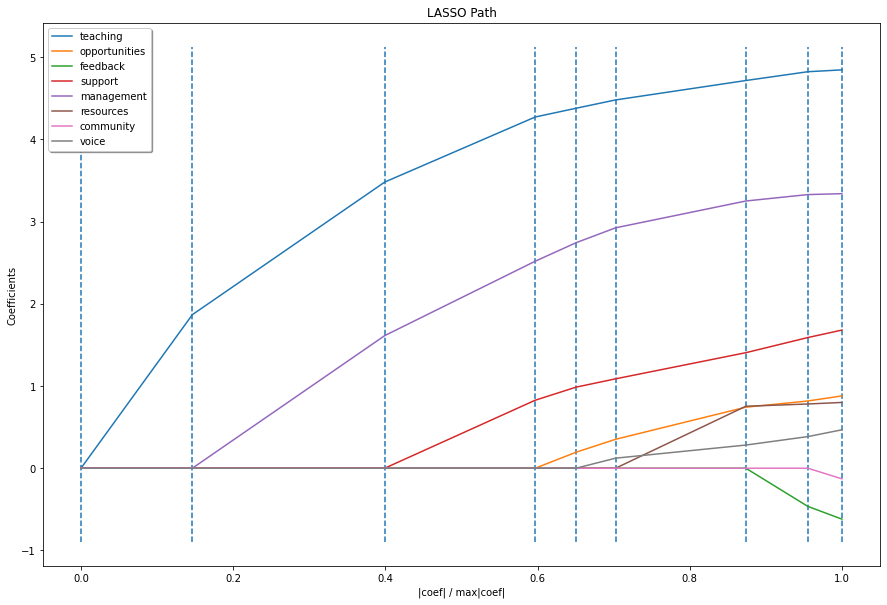

OSError: [Errno 30] Read-only file system: '/lasso_path.png'

<Figure size 432x288 with 0 Axes>

In [94]:

## Scale the variables
std = StandardScaler()
std.fit(X_train_val.values)

X_tr = std.transform(X_train_val.values)

## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train_val.values, method='lasso')

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train_val.columns, shadow=True)
plt.show()
plt.savefig("/lasso_path.png",dpi=150);

In [90]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val.values)

StandardScaler()

In [68]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)

In [69]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,400)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

LassoCV(alphas=array([1.00000000e-02, 1.02335205e-02, 1.04724941e-02, 1.07170483e-02,
       1.09673133e-02, 1.12234225e-02, 1.14855124e-02, 1.17537227e-02,
       1.20281961e-02, 1.23090791e-02, 1.25965213e-02, 1.28906759e-02,
       1.31916996e-02, 1.34997528e-02, 1.38149996e-02, 1.41376081e-02,
       1.44677502e-02, 1.48056018e-02, 1.51513429e-02, 1.55051578e-02,
       1.58672350e-02, 1.62377674e-0...
       5.88062599e+01, 6.01795064e+01, 6.15848211e+01, 6.30229527e+01,
       6.44946677e+01, 6.60007502e+01, 6.75420029e+01, 6.91192469e+01,
       7.07333228e+01, 7.23850907e+01, 7.40754307e+01, 7.58052437e+01,
       7.75754513e+01, 7.93869969e+01, 8.12408458e+01, 8.31379858e+01,
       8.50794280e+01, 8.70662068e+01, 8.90993810e+01, 9.11800339e+01,
       9.33092744e+01, 9.54882369e+01, 9.77180827e+01, 1.00000000e+02]),
        cv=5)

In [70]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.01

In [71]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, lasso_model.coef_))

[('teaching', 4.840632924206748),
 ('opportunities', 0.8612699497906318),
 ('feedback', -0.5746003031681449),
 ('support', 1.6535958365922931),
 ('management', 3.337217204641248),
 ('resources', 0.7946063530763063),
 ('community', -0.09126836662628977),
 ('voice', 0.44344615324062325)]

In [72]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [73]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.536480238174812

In [74]:
r2_score(y_test, test_set_pred)

0.70781863758755

# Ridge

In [75]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,400)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

RidgeCV(alphas=array([1.00000000e-02, 1.02335205e-02, 1.04724941e-02, 1.07170483e-02,
       1.09673133e-02, 1.12234225e-02, 1.14855124e-02, 1.17537227e-02,
       1.20281961e-02, 1.23090791e-02, 1.25965213e-02, 1.28906759e-02,
       1.31916996e-02, 1.34997528e-02, 1.38149996e-02, 1.41376081e-02,
       1.44677502e-02, 1.48056018e-02, 1.51513429e-02, 1.55051578e-02,
       1.58672350e-02, 1.62377674e-0...
       5.88062599e+01, 6.01795064e+01, 6.15848211e+01, 6.30229527e+01,
       6.44946677e+01, 6.60007502e+01, 6.75420029e+01, 6.91192469e+01,
       7.07333228e+01, 7.23850907e+01, 7.40754307e+01, 7.58052437e+01,
       7.75754513e+01, 7.93869969e+01, 8.12408458e+01, 8.31379858e+01,
       8.50794280e+01, 8.70662068e+01, 8.90993810e+01, 9.11800339e+01,
       9.33092744e+01, 9.54882369e+01, 9.77180827e+01, 1.00000000e+02]),
        cv=5)

In [76]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
ridge_model.alpha_

34.58176201952377

In [77]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, ridge_model.coef_))

[('teaching', 4.837036543016415),
 ('opportunities', 0.8831494591017031),
 ('feedback', -0.6134594407200143),
 ('support', 1.6788119291895207),
 ('management', 3.337014462169051),
 ('resources', 0.801086450209899),
 ('community', -0.12835638246244346),
 ('voice', 0.46891067830392363)]

In [78]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [79]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.536934440147411

In [80]:
r2_score(y_test, test_set_pred)

0.7077239327330098